# Ross Ice Shelf gravity reduction

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pathlib
import pickle
import seaborn as sns

sns.set_theme()
import os
import string

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

In [2]:
# from pygmt import session_management

# session_management.end()
# session_management.begin()

# Set region and parameters

In [3]:
# polygon = regions.draw_region()

In [4]:
# starting_region = utils.polygon_to_region(polygon)

In [5]:
starting_region = [-580e3, 420e3, -1420e3, -420e3]

inversion_region = starting_region
buffer_region = vd.pad_region(starting_region, 40e3)
# inversion_region, buffer_region = utils.alter_region(
#     starting_region=starting_region,
#     zoom=30e3,
#     # n_shift=0e3,
#     # w_shift=-0e3,
#     buffer=30e3,
# )

# set densities
air_density = 1
ice_density = 917  # +/- 5, from Griggs and Bamber 2009/2011
water_density = 1024  # +/- 5, from Griggs and Bamber 2009/2011
sediment_density = 2300  # will likely change this

# set layer parameters
layer_spacing = 5e3
registration = "g"

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 5e3

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

layer spacing: 5000.0m
registration: g
inversion region =  [-580000.0, 420000.0, -1420000.0, -420000.0]
buffer region =  (-620000.0, 460000.0, -1460000.0, -380000.0)


# Load data

## topographic layers
* Surface, Icebase, Bed

From notebook `prepare_grids`

In [6]:
# SURFACE
fname = "inversion_layers/bedmachine_surface.zarr"
# fname= "inversion_layers/bedmap2_surface.zarr"
surface_full = xr.open_zarr(fname).surface

# ICEBASE
fname = "inversion_layers/bedmachine_icebase.zarr"
# fname =  "inversion_layers/bedmap2_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase

# BED
fname = "inversion_layers/bedmachine_bed.zarr"
bedmachine_bed_full = xr.open_zarr(fname).bed

fname = "inversion_layers/bedmap2_bed.zarr"
bedmap_bed_full = xr.open_zarr(fname).bed

# bedmachine outside RIS, riggs inside
fname = "inversion_layers/bed_from_constraints_5k.zarr"
starting_bed_full = xr.open_zarr(fname).bed

# bedmachine outside RIS, bedmap2 inside RIS, and RIGGS points within RIS
# bed = "inversion_layers/bedmap_bedmachine_merge.zarr"

# BASEMENT
# Ross Embayment basement merged to bedmachine bed
# basement = "inversion_layers/bed_basement_merged.zarr"
# Ross Embayment basement merged to ANTASed basement
# basement = "inversion_layers/ANTASed_magnetics_merged_basement.zarr"
# basement = xr.open_zarr(basement).basement

grids = [
    surface_full,
    icebase_full,
    starting_bed_full,
    bedmap_bed_full,
    bedmachine_bed_full,
]

for g in grids:
    print(utils.get_grid_info(g))

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -66.0, 4345.72509766, 'g')
(1000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -3423.73608398, 4345.72509766, 'g')
(5000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -4414.96582031, 4053.66796875, 'g')
(1000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -5162.05029297, 3722.66943359, 'g')
(1000.0, [-960000.0, 800000.0, -1800000.0, -60000.0], -4424.22265625, 4345.72509766, 'g')


### resample to same spacing / region

In [7]:
surface = fetch.resample_grid(
    surface_full,
    spacing=1e3,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
icebase = fetch.resample_grid(
    icebase_full,
    spacing=1e3,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
icebase_layer_spacing = fetch.resample_grid(
    icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
starting_bed = fetch.resample_grid(
    starting_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmap_bed = fetch.resample_grid(
    bedmap_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmachine_bed = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# ensure layers never cross
icebase = xr.where(icebase > surface, surface, icebase)
starting_bed = xr.where(
    starting_bed > icebase_layer_spacing,
    icebase_layer_spacing,
    starting_bed,
)

grids = [
    surface,
    icebase,
    icebase_layer_spacing,
    starting_bed,
    bedmap_bed,
    bedmachine_bed,
]

for g in grids:
    print(utils.get_grid_info(g))

# set conventional names
# surface = surface.rename({"x": "easting", "y": "northing"})
# icebase = icebase.rename({"x": "easting", "y": "northing"})
# bed = bed.rename({"x": "easting", "y": "northing"})
bedmachine_bed = bedmachine_bed.rename({"x": "easting", "y": "northing"})
bedmap_bed = bedmap_bed.rename({"x": "easting", "y": "northing"})

spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
(1000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -61.0, 4345.72509766, 'g')
(1000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -3423.73608398, 4345.72509766, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -3012.53222656, 4053.66796875, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -3737.66113281, 4053.66796875, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -4043.64941406, 3574.09716797, 'g')
(5000.0, [-620000.0, 460000.0, -1460000.0, -380000.0], -3737.66113281, 4053.66796875, 'g')


## bed constraints
from notebook `RIS_bathymetry_data.ipynb`

In [8]:
# constraints_fname = "data/bedmap1.csv.gz"
constraints_fname = "data/bed_constraints_5k.csv.gz"

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints,
    # buffer_region,
    inversion_region,
    names=("easting", "northing"),
)

constraints["weights"] = 1 / (constraints.z_error**2)

print(f"bathymetry control points:{len(constraints)}")
constraints  # .describe()

bathymetry control points:21404


northing        easting       upward    z_error  inside  \
26904  -1.420000e+06 -580000.000000 -3435.192383  10.000000   False   
26905  -1.420000e+06 -575000.000000 -3433.737305  10.000000   False   
26906  -1.420000e+06 -570000.000000 -3486.636963  10.000000   False   
26907  -1.420000e+06 -565000.000000 -3552.369141  10.000000   False   
26908  -1.420000e+06 -560000.000000 -3542.798096  10.000000   False   
...              ...            ...          ...        ...     ...   
104190 -8.164639e+05 -218050.118799  -564.000000  28.169892    True   
104191 -1.087485e+06 -452466.872984  -714.000000  35.974844    True   
104192 -1.033177e+06 -214445.845201  -512.000000  25.265916    True   
104193 -8.266453e+05 -197189.312136  -583.000000  29.304673    True   
104194 -1.086833e+06  111072.987479  -652.000000  31.932102    True   

        station_ID   weights  
26904          NaN  0.010000  
26905          NaN  0.010000  
26906          NaN  0.010000  
26907          NaN  0.010000  
26908          NaN  0.010000  
...            ...       ...  
104190        19.0  0.001260  
104191        19.0  0.000773  
104192        19.0  0.001566  
104193         1.0  0.001164  
104194        19.0  0.000981  

[21404 rows x 7 columns]

In [9]:
# maps.plot_grd(
#     starting_bed,
#     points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.05c",
# )

## Load gravity disturbance data

github repository [RIS_grav_bath_data](https://github.com/mdtanker/RIS_grav_bath_data), contains a compilation of gravity data and bed elevation constraints for the Ross Ice Shelf region. Load the data into a pandas dataframe with the below cell. 

> **Note:** this repo is currently private, so it requires a github authentication token!

In [10]:
# load gravity data

# fname = "inversion_layers/rosetta_eq_source_1k_up_continued.zarr"
# fname = "inversion_layers/rosetta_1k_up_continued_20k_masked.zarr"
# grav_grid_full = xr.open_zarr(fname).load()

grav = pd.read_csv(
    "inversion_layers/rosetta_eq_source_1k_up_continued.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

grav

# grav_grid_full.Gobs.plot(robust=True)

northing   easting   test  upward       Gobs
0     -1390000.0   47500.0   True  1000.0   3.640505
1     -1390000.0   50000.0  False  1000.0   3.893493
2     -1390000.0   52500.0   True  1000.0   4.162121
3     -1390000.0   55000.0  False  1000.0   4.447213
4     -1390000.0   57500.0   True  1000.0   4.748742
...          ...       ...    ...     ...        ...
92593  -437500.0 -200000.0   True  1000.0 -15.280410
92594  -437500.0 -197500.0   True  1000.0 -15.061267
92595  -437500.0 -195000.0   True  1000.0 -14.795921
92596  -437500.0 -192500.0   True  1000.0 -14.494022
92597  -437500.0 -190000.0   True  1000.0 -14.166404

[92598 rows x 5 columns]

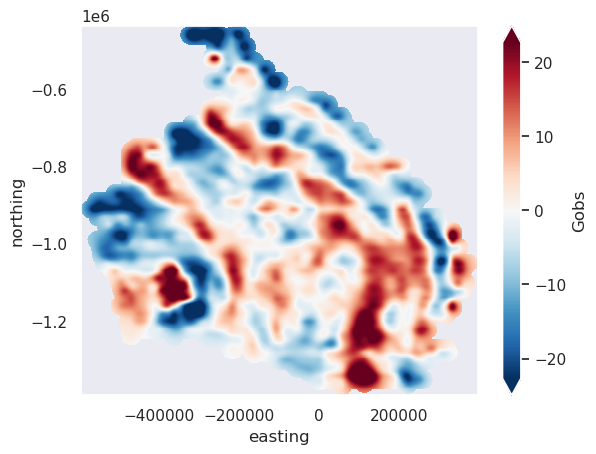

In [11]:
grav.set_index(["northing", "easting"]).to_xarray().Gobs.plot(robust=True)

In [13]:
# grav_grid = inv_utils.filter_grid(
#     grav_grid_full.Gobs,
#     50e3,
#     filt_type="lowpass",
# )

# grav_grid = grav_grid_full.Gobs

# print(utils.get_grid_info(grav_grid))

# grav_grid.plot()

In [14]:
# grav = vd.grid_to_table(grav_grid_full)
# grav = grav[grav.Gobs.notna()]
# # grav["upward"] = 1000
# grav.describe()

In [12]:
grav_df = inv_utils.prep_grav_data(
    grav,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting", "northing", "upward"),
)
grav_df.head()

northing  easting   test  upward      Gobs
0 -1390000.0  47500.0   True  1000.0  3.640505
1 -1390000.0  50000.0  False  1000.0  3.893493
2 -1390000.0  52500.0   True  1000.0  4.162121
3 -1390000.0  55000.0  False  1000.0  4.447213
4 -1390000.0  57500.0   True  1000.0  4.748742

# Corrections as contrasts (zref=0)

## Surface prisms

In [13]:
# create prisms around surface
# positive densities above reference, negative below
density = ice_density - air_density
print(f"Surface density contrast: {density}kgm-3")

zref = np.nanmean(surface)
# zref = 0
surface_prisms = inv_utils.grids_to_prisms(
    surface=surface,
    reference=zref,
    density=xr.where(surface >= zref, density, -density),
    input_coord_names=["x", "y"],
)

Surface density contrast: 916kgm-3


## Icebase prisms

In [14]:
# create prisms around icebase
# positive densities above reference, negative below
density = water_density - ice_density
print(f"Icebase density contrast: {density}kgm-3")

zref = np.nanmean(icebase)
# zref = 0
icebase_prisms = inv_utils.grids_to_prisms(
    surface=icebase,
    reference=zref,
    density=xr.where(icebase >= zref, density, -density),
    input_coord_names=["x", "y"],
)

Icebase density contrast: 107kgm-3


## Starting bed prisms

In [15]:
# create prisms around bed
# positive densities above reference, negative below
density = sediment_density - water_density
print(f"Bed density contrast: {density}kgm-3")

zref = np.nanmean(starting_bed)
# zref = 0
bed_prisms = inv_utils.grids_to_prisms(
    surface=starting_bed,
    reference=zref,
    density=xr.where(starting_bed >= zref, density, -density),
    input_coord_names=["x", "y"],
)

Bed density contrast: 1276kgm-3


In [16]:
# calculate forward gravity
forward_grav_grid, forward_grav_df = inv_utils.forward_grav_of_prismlayer(
    [surface_prisms, icebase_prisms, bed_prisms],
    grav_df,
    names=["surface_prisms", "icebase_prisms", "bed_prisms"],
    progressbar=True,
    plot=False,
)

grav_df["surface_forward"] = forward_grav_df.surface_prisms
grav_df["icebase_forward"] = forward_grav_df.icebase_prisms
grav_df["bed_forward"] = forward_grav_df.bed_prisms

grav_df.describe()

  0%|                                                 | 0/92518 [00:00<?, ?it/s]

  0%|                                                 | 0/92518 [00:00<?, ?it/s]

  0%|                                                 | 0/92518 [00:00<?, ?it/s]

northing        easting   upward          Gobs  surface_forward  \
count  9.251800e+04   92518.000000  92518.0  92518.000000     92518.000000   
mean  -9.774803e+05  -97107.022417   1000.0     -0.268222       -18.140200   
std    2.136572e+05  234474.012656      0.0     10.792959         3.061163   
min   -1.390000e+06 -580000.000000   1000.0    -35.006585       -34.994161   
25%   -1.147500e+06 -277500.000000   1000.0     -7.363493       -19.194658   
50%   -9.900000e+05 -102500.000000   1000.0     -0.175491       -18.927617   
75%   -8.225000e+05   90000.000000   1000.0      6.691260       -18.188273   
max   -4.375000e+05  395000.000000   1000.0     34.301253        17.511679   

       icebase_forward   bed_forward  
count     92518.000000  92518.000000  
mean         -1.507756    -19.165401  
std           0.799791     10.529634  
min          -5.402379    -89.391614  
25%          -1.839410    -23.866783  
50%          -1.409021    -18.690538  
75%          -1.204281    -13.833556  
max           4.451169     63.680871

## Correct the observed gravity

In [31]:
grav_df["terrain_effect"] = grav_df.surface_forward + grav_df.icebase_forward

grav_df["Gobs_corr_contrasts"] = grav_df.Gobs - grav_df.terrain_effect

grav_df.describe()

northing        easting   upward          Gobs  surface_forward  \
count  9.251800e+04   92518.000000  92518.0  92518.000000     92518.000000   
mean  -9.774803e+05  -97107.022417   1000.0     -0.268222       -18.140200   
std    2.136572e+05  234474.012656      0.0     10.792959         3.061163   
min   -1.390000e+06 -580000.000000   1000.0    -35.006585       -34.994161   
25%   -1.147500e+06 -277500.000000   1000.0     -7.363493       -19.194658   
50%   -9.900000e+05 -102500.000000   1000.0     -0.175491       -18.927617   
75%   -8.225000e+05   90000.000000   1000.0      6.691260       -18.188273   
max   -4.375000e+05  395000.000000   1000.0     34.301253        17.511679   

       icebase_forward   bed_forward  terrain_effect     Gobs_corr  \
count     92518.000000  92518.000000    92518.000000  92518.000000   
mean         -1.507756    -19.165401      -19.647956     19.379734   
std           0.799791     10.529634        3.109053     10.834414   
min          -5.402379    -89.391614      -36.624508    -32.771128   
25%          -1.839410    -23.866783      -20.485096     12.670163   
50%          -1.409021    -18.690538      -20.369746     19.777290   
75%          -1.204281    -13.833556      -20.190786     26.362566   
max           4.451169     63.680871       21.909729     54.892395   

       Gobs_corr_shift        misfit  Gobs_corr_contrasts  
count     92518.000000  92518.000000         92518.000000  
mean        -15.035900      4.129501            19.379734  
std          10.834414     14.340701            10.834414  
min         -67.186761   -130.280213           -32.771128  
25%         -21.745470     -3.348490            12.670163  
50%         -14.638343      4.197687            19.777290  
75%          -8.053067     12.041348            26.362566  
max          20.476762     66.355838            54.892395

## Misfit

In [32]:
grav_df = inv.misfit(
    input_grav=grav_df,
    input_forward_column="bed_forward",
    input_grav_column="Gobs_corr_contrasts",
    constraints=constraints,
)

# grav_df["total_misfit"] = grav_df.Gobs_corr - grav_df.bed_forward
grav_df.describe()

DC shifted observed gravity by 34.42mGal to match forward gravity.


northing        easting   upward          Gobs  surface_forward  \
count  9.251800e+04   92518.000000  92518.0  92518.000000     92518.000000   
mean  -9.774803e+05  -97107.022417   1000.0     -0.268222       -18.140200   
std    2.136572e+05  234474.012656      0.0     10.792959         3.061163   
min   -1.390000e+06 -580000.000000   1000.0    -35.006585       -34.994161   
25%   -1.147500e+06 -277500.000000   1000.0     -7.363493       -19.194658   
50%   -9.900000e+05 -102500.000000   1000.0     -0.175491       -18.927617   
75%   -8.225000e+05   90000.000000   1000.0      6.691260       -18.188273   
max   -4.375000e+05  395000.000000   1000.0     34.301253        17.511679   

       icebase_forward   bed_forward  terrain_effect     Gobs_corr  \
count     92518.000000  92518.000000    92518.000000  92518.000000   
mean         -1.507756    -19.165401      -19.647956     19.379734   
std           0.799791     10.529634        3.109053     10.834414   
min          -5.402379    -89.391614      -36.624508    -32.771128   
25%          -1.839410    -23.866783      -20.485096     12.670163   
50%          -1.409021    -18.690538      -20.369746     19.777290   
75%          -1.204281    -13.833556      -20.190786     26.362566   
max           4.451169     63.680871       21.909729     54.892395   

       Gobs_corr_shift  Gobs_corr_contrasts  Gobs_corr_contrasts_shift  \
count     92518.000000         92518.000000               92518.000000   
mean        -15.035900            19.379734                 -15.035900   
std          10.834414            10.834414                  10.834414   
min         -67.186761           -32.771128                 -67.186761   
25%         -21.745470            12.670163                 -21.745470   
50%         -14.638343            19.777290                 -14.638343   
75%          -8.053067            26.362566                  -8.053067   
max          20.476762            54.892395                  20.476762   

             misfit  
count  92518.000000  
mean       4.129501  
std       14.340701  
min     -130.280213  
25%       -3.348490  
50%        4.197687  
75%       12.041348  
max       66.355838

## Save and load results

In [33]:
grav_df.to_csv(
    "data/RIS_topo_corrections.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [34]:
grav_df = pd.read_csv(
    "data/RIS_topo_corrections.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

grav_df.describe()

northing        easting   upward          Gobs  surface_forward  \
count  9.251800e+04   92518.000000  92518.0  92518.000000     92518.000000   
mean  -9.774803e+05  -97107.022417   1000.0     -0.268222       -18.140200   
std    2.136572e+05  234474.012656      0.0     10.792959         3.061163   
min   -1.390000e+06 -580000.000000   1000.0    -35.006585       -34.994161   
25%   -1.147500e+06 -277500.000000   1000.0     -7.363493       -19.194658   
50%   -9.900000e+05 -102500.000000   1000.0     -0.175491       -18.927617   
75%   -8.225000e+05   90000.000000   1000.0      6.691260       -18.188273   
max   -4.375000e+05  395000.000000   1000.0     34.301253        17.511679   

       icebase_forward   bed_forward  terrain_effect     Gobs_corr  \
count     92518.000000  92518.000000    92518.000000  92518.000000   
mean         -1.507756    -19.165401      -19.647956     19.379734   
std           0.799791     10.529634        3.109053     10.834414   
min          -5.402379    -89.391614      -36.624508    -32.771128   
25%          -1.839410    -23.866783      -20.485096     12.670163   
50%          -1.409021    -18.690538      -20.369746     19.777290   
75%          -1.204281    -13.833556      -20.190786     26.362566   
max           4.451169     63.680871       21.909729     54.892395   

       Gobs_corr_shift  Gobs_corr_contrasts  Gobs_corr_contrasts_shift  \
count     92518.000000         92518.000000               92518.000000   
mean        -15.035900            19.379734                 -15.035900   
std          10.834414            10.834414                  10.834414   
min         -67.186761           -32.771128                 -67.186761   
25%         -21.745470            12.670163                 -21.745470   
50%         -14.638343            19.777290                 -14.638343   
75%          -8.053067            26.362566                  -8.053067   
max          20.476762            54.892395                  20.476762   

             misfit  
count  92518.000000  
mean       4.129501  
std       14.340701  
min     -130.280213  
25%       -3.348490  
50%        4.197687  
75%       12.041348  
max       66.355838

## Plot grids

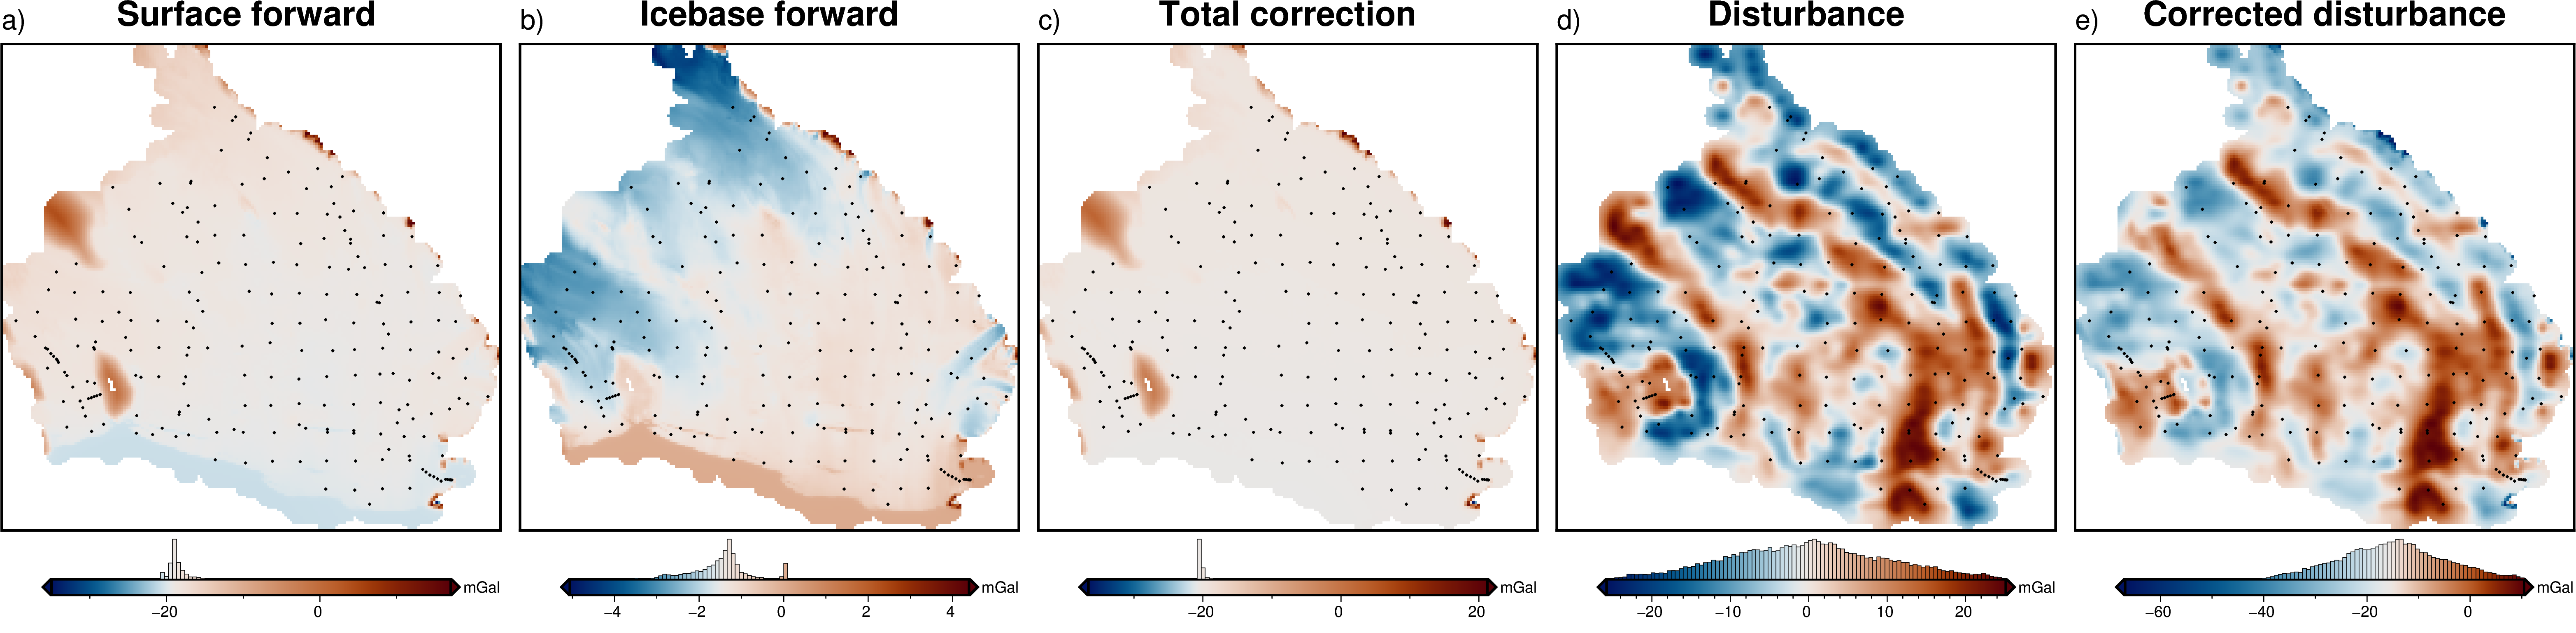

In [25]:
grav_grids = (
    grav_df[grav_df.test == False].set_index(["northing", "easting"]).to_xarray()
)

grids = [
    grav_grids.surface_forward,
    grav_grids.icebase_forward,
    grav_grids.terrain_effect,
    grav_grids.Gobs,
    grav_grids.Gobs_corr_shift,
]

titles = [
    "Surface forward ",
    "Icebase forward",
    "Total correction",
    "Disturbance",
    "Corrected disturbance",
]

# lims = [utils.get_min_max(i, robust=True) for i in grids]
# lims = [min([i for i in lims[0]]), max([i for i in lims[1]])]
# lims = utils.get_min_max(grids[2])

for i, g in enumerate(grids):
    if i == 0:
        fig = None
        origin_shift = "initialize"
    else:
        fig = fig
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=10,
        cmap=f"vik+h{np.nanmedian(g)}",
        # cpt_lims=lims,
        title=titles[i],
        cbar_unit="mGal",
        points=constraints[constraints.inside].rename(
            columns={"easting": "x", "northing": "y"}
        ),
        points_style="x0.05c",
        hist=True,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
    )
    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[i]})",
        font="16p,Helvetica,black",
        offset="j0/.3",
        no_clip=True,
    )

fig.show()

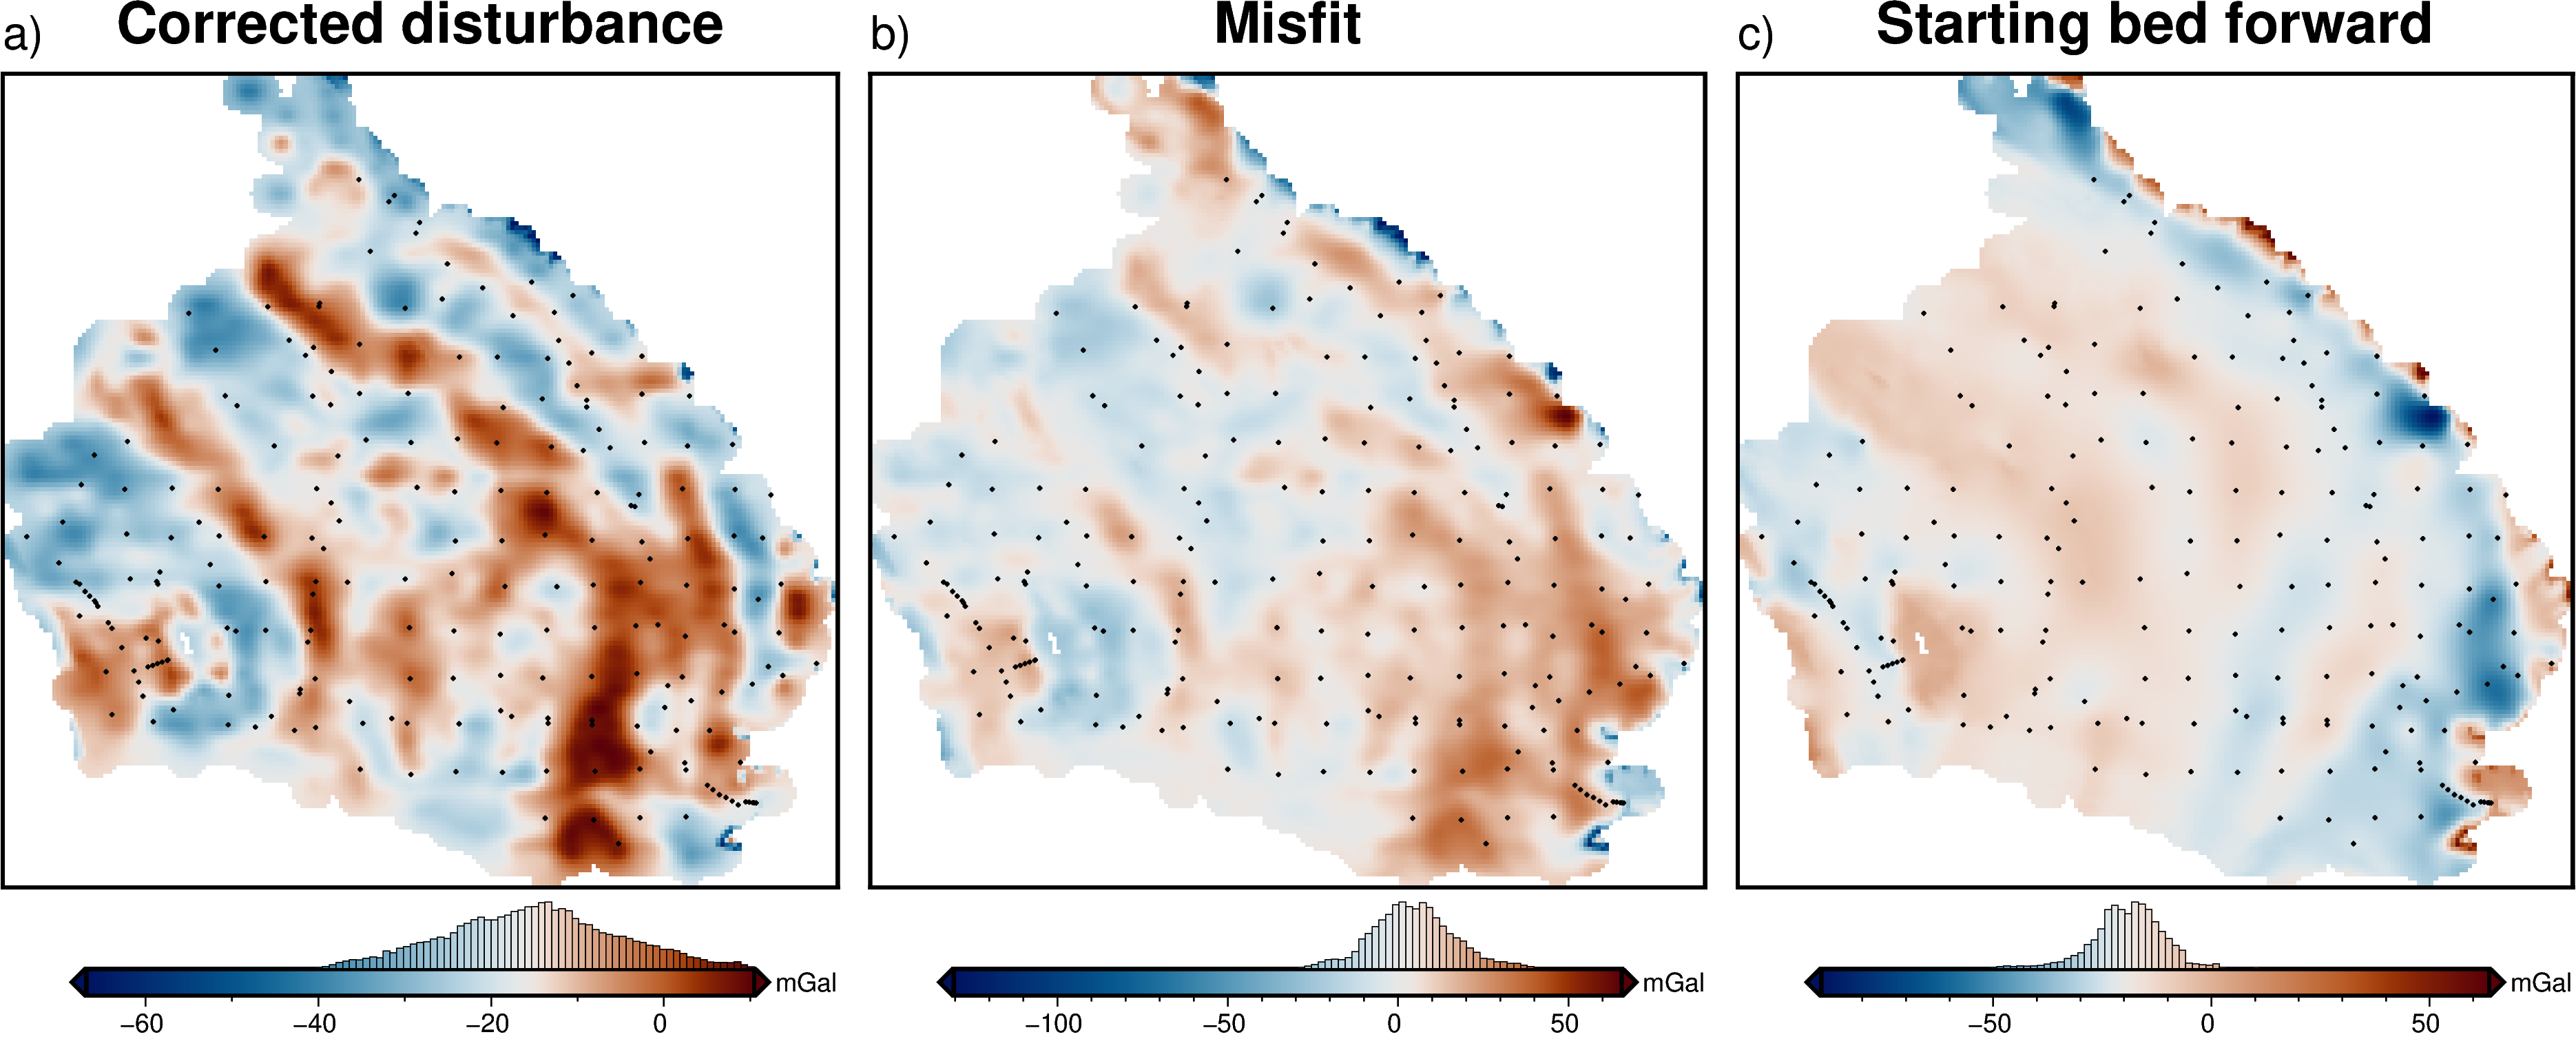

In [27]:
grav_grids = (
    grav_df[grav_df.test == False].set_index(["northing", "easting"]).to_xarray()
)

grids = [
    grav_grids.Gobs_corr_shift,
    grav_grids.misfit,
    grav_grids.bed_forward,
]

titles = [
    "Corrected disturbance",
    "Misfit",
    "Starting bed forward",
]

# lims = [utils.get_min_max(i, robust=True) for i in grids]
# lims = [min([i for i in lims[0]]), max([i for i in lims[1]])]
# lims = utils.get_min_max(grids[2])

for i, g in enumerate(grids):
    if i == 0:
        fig = None
        origin_shift = "initialize"
    else:
        fig = fig
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=10,
        cmap=f"vik+h{np.nanmedian(g)}",
        # cpt_lims=lims,
        title=titles[i],
        cbar_unit="mGal",
        points=constraints[constraints.inside].rename(
            columns={"easting": "x", "northing": "y"}
        ),
        points_style="x0.05c",
        hist=True,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
    )
    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[i]})",
        font="16p,Helvetica,black",
        offset="j0/.3",
        no_clip=True,
    )

fig.show()

## Plot profiles

In [122]:
# lines = profile.draw_lines()

In [40]:
# # get clicked points
# df = utils.shapes_to_df(lines)
# # extract first and last
# a = (df.x.iloc[0], df.y.iloc[0])
# b = (df.x.iloc[-1], df.y.iloc[-1])

# siple coast profile
a = (-514139.22589550324, -886012.3396426054)
b = (-30871.591933855758, -595196.2984418197)

# ice front to CIR
a = (48403.646330947464, -1387918.0291082778)
b = (-221877.26567443524, -613795.4844574957)

In [24]:
grav_df

northing   easting   test  upward       Gobs  surface_forward  \
0     -1390000.0   47500.0   True  1000.0   2.884010        -2.130958   
1     -1390000.0   50000.0  False  1000.0   3.088962        -2.130490   
2     -1390000.0   52500.0   True  1000.0   3.303728        -2.129824   
3     -1390000.0   55000.0  False  1000.0   3.528447        -2.128705   
4     -1390000.0   57500.0   True  1000.0   3.762495        -2.126157   
...          ...       ...    ...     ...        ...              ...   
91765  -437500.0 -200000.0   True  1000.0 -10.076840        14.469784   
91766  -437500.0 -197500.0   True  1000.0 -10.018881        31.548448   
91767  -437500.0 -195000.0   True  1000.0  -9.918536        22.703218   
91768  -437500.0 -192500.0   True  1000.0  -9.780614        21.006531   
91769  -437500.0 -190000.0   True  1000.0  -9.612256        22.233066   

       icebase_forward  terrain_effect  Gobs_corr  bed_forward  \
0            -0.255159       -2.386117   5.270127   -32.904833   
1            -0.255159       -2.385649   5.474611   -32.945225   
2            -0.255139       -2.384963   5.688691   -32.814109   
3            -0.255067       -2.383772   5.912220   -32.652187   
4            -0.254832       -2.380989   6.143484   -32.495949   
...                ...             ...        ...          ...   
91765         1.532502       16.002286 -26.079125    17.467913   
91766         3.542050       35.090498 -45.109379    25.514781   
91767         2.504928       25.208146 -35.126682    33.384809   
91768         2.315717       23.322248 -33.102862    32.089096   
91769         2.479445       24.712510 -34.324767    30.553621   

       Gobs_corr_shift      misfit  
0           -26.012518    6.892315  
1           -25.808035    7.137190  
2           -25.593954    7.220155  
3           -25.370426    7.281762  
4           -25.139162    7.356788  
...                ...         ...  
91765       -57.361771  -74.829683  
91766       -76.392024 -101.906806  
91767       -66.409328  -99.794136  
91768       -64.385507  -96.474602  
91769       -65.607412  -96.161033  

[91770 rows x 12 columns]

In [38]:
grav_grids = (
    grav_df[grav_df.test == False].set_index(["northing", "easting"]).to_xarray()
)

# extract layers for profile plot
topo_grids = [
    surface,
    icebase,
    starting_bed,
]
topo_names = [
    "ice surface",
    "ice base",
    "bed",
]

data_grids = [
    grav_grids.surface_forward,
    grav_grids.icebase_forward,
    grav_grids.terrain_effect,
    grav_grids.Gobs,
    grav_grids.Gobs_corr,
]
data_names = [
    "surface forward",
    "icebase forward",
    "terrain effect",
    "Gobs",
    "Gobs_corr",
]

layers_dict = profile.make_data_dict(
    names=topo_names,
    grids=topo_grids,
    colors=["lightskyblue", "darkblue", "lightbrown"],
)

data_dict = profile.make_data_dict(
    names=data_names,
    grids=data_grids,
    colors=[
        "blue",
        "darkorange",
        "black",
        "red",
        "green",
        "cyan",
    ],
    axes=[0, 0, 0, 0, 0, 0],
)

In [34]:
grav_grids = (
    grav_df[grav_df.test == False].set_index(["northing", "easting"]).to_xarray()
)

# extract layers for profile plot
topo_grids = [
    surface,
    icebase,
    starting_bed,
]
topo_names = [
    "ice surface",
    "ice base",
    "bed_forward",
]

data_grids = [
    grav_grids.Gobs,
    grav_grids.Gobs_corr,
    grav_grids.total_misfit,
    grav_grids.bed_forward,
]
data_names = [
    "Gobs",
    "Gobs_corr",
    "total_misfit",
    "bed",
]

layers_dict = profile.make_data_dict(
    names=topo_names,
    grids=topo_grids,
    colors=["lightskyblue", "darkblue", "lightbrown"],
)

data_dict = profile.make_data_dict(
    names=data_names,
    grids=data_grids,
    colors=[
        "blue",
        "darkorange",
        "black",
        "red",
        "green",
        "cyan",
    ],
    axes=[0, 0, 0, 0, 0, 0],
)

legend [WARNING]: File <stdin> is empty!
gmtset [WARNING]: Representation of font type not recognized. Using default.


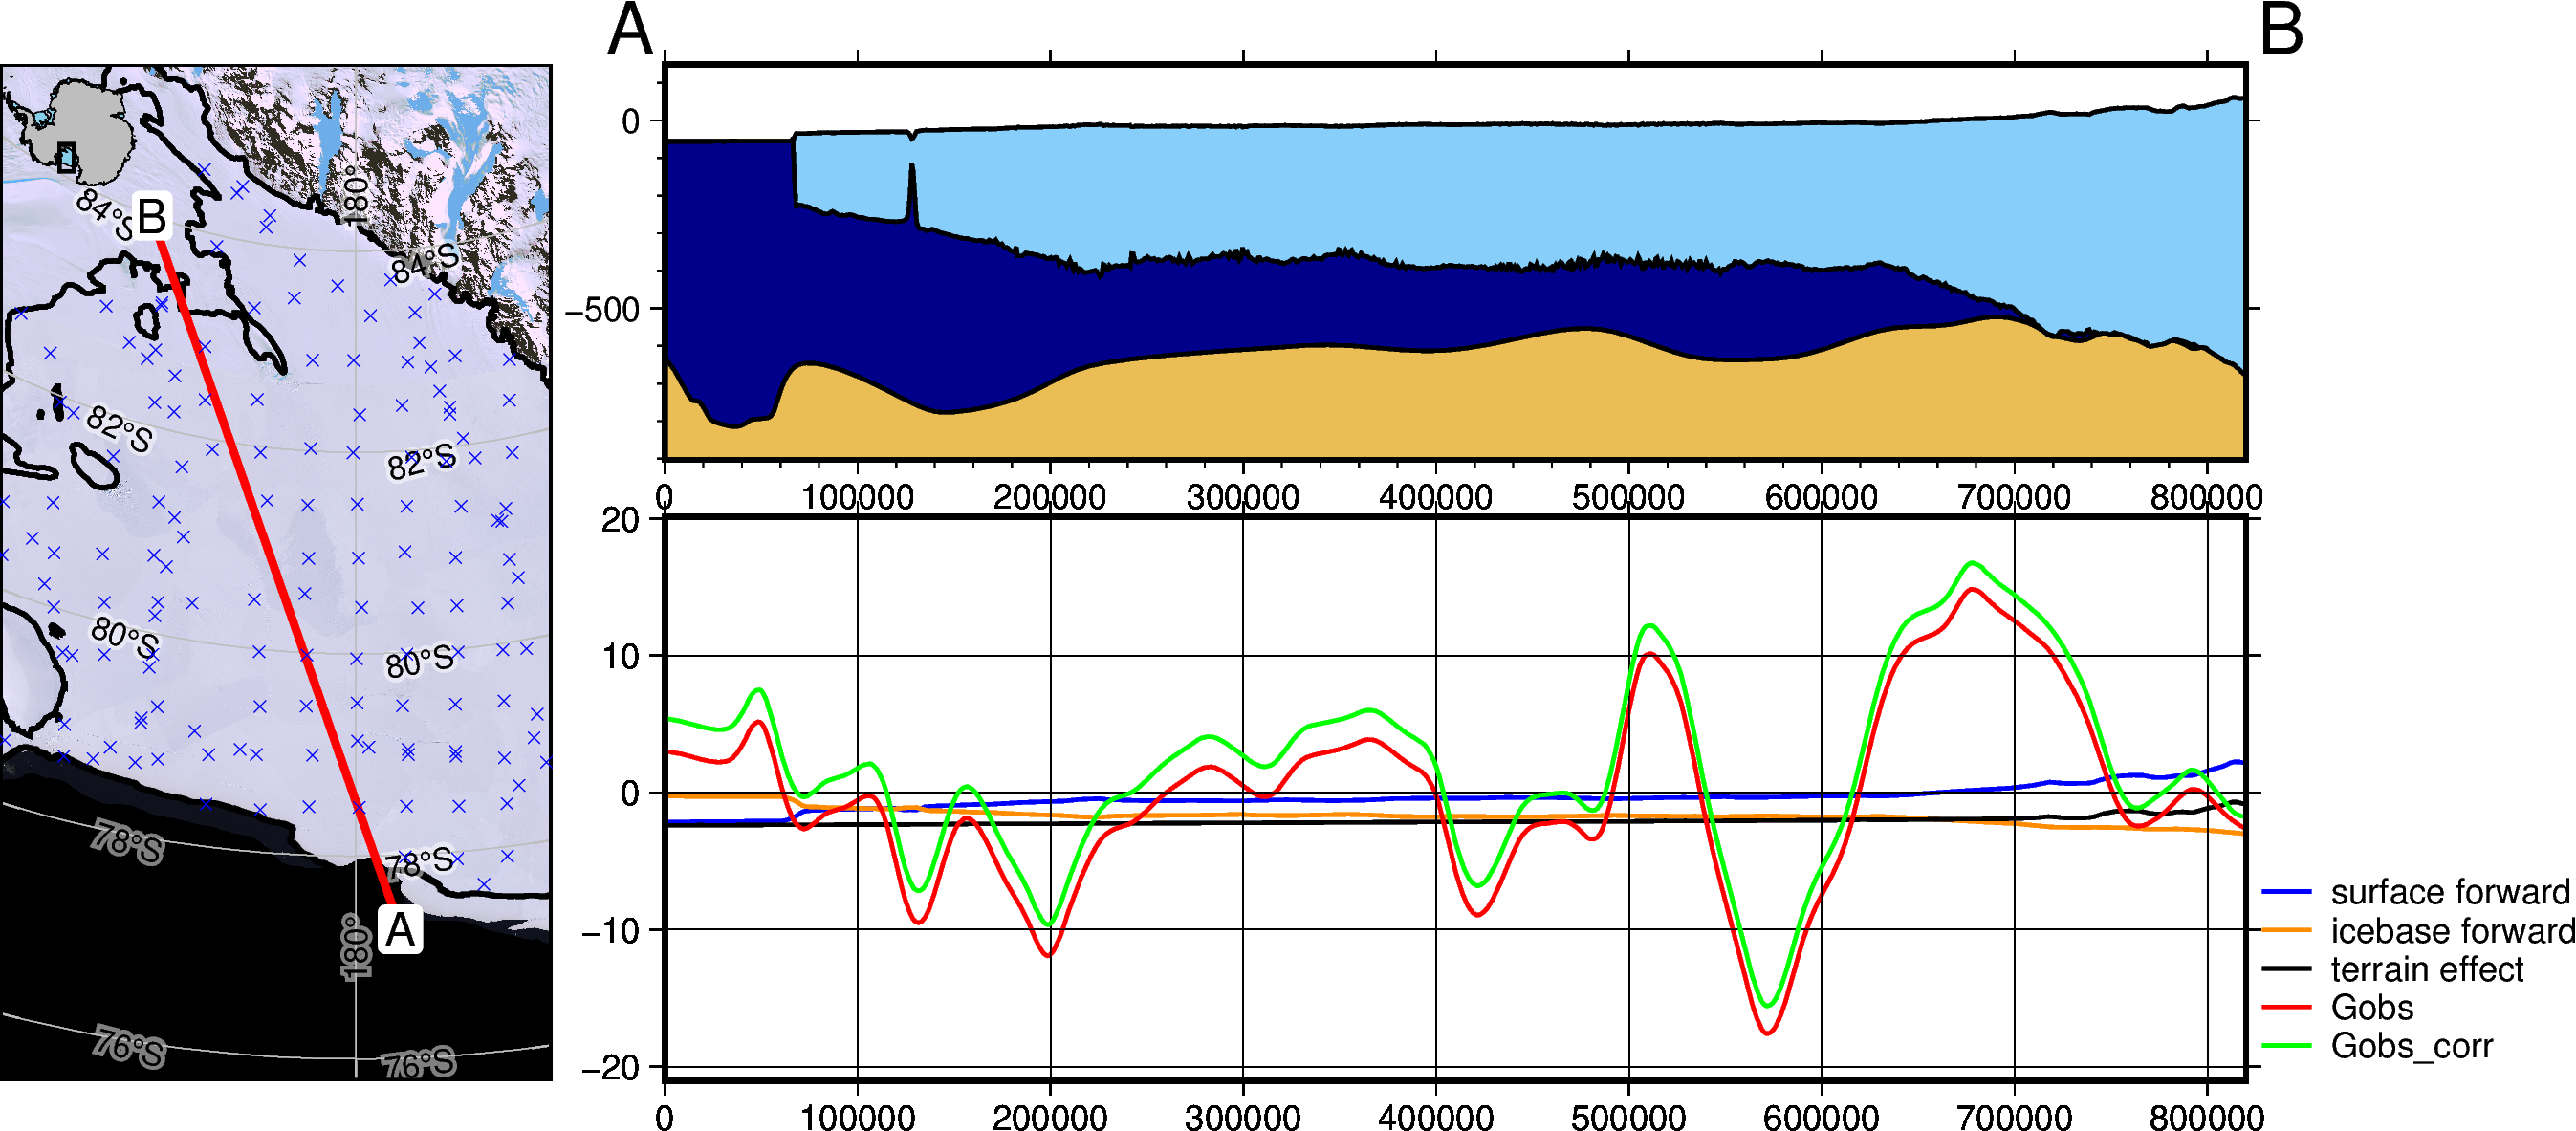

In [41]:
fig = profile.plot_profile(
    "points",
    start=a,
    stop=b,
    # num=1000,
    add_map=True,
    map_buffer=0.2,
    subplot_orientation="horizontal",
    # subplot_orientation='vertical',
    data_dict=data_dict,
    layers_dict=layers_dict,
    share_yaxis=True,
    map_points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    data_height=5,
)
fig.show()

# Terrain-free gravity disturbance relative to water

Start by filling everything above ellipsoid with ice, and everything below with water. Then correct the remaining anomalous masses relative to ice if above ellipsoid, or relative to water if below ellipsoid.

In [67]:
ice_surface_prisms = inv_utils.grids_to_prisms(
    surface=surface,
    reference=0,
    density=xr.where(
        surface >= 0, ice_density - air_density, air_density - ice_density
    ),
    input_coord_names=["x", "y"],
)

water_surface_prisms = inv_utils.grids_to_prisms(
    surface=icebase,
    reference=0,
    density=xr.where(
        icebase >= 0, water_density - ice_density, ice_density - water_density
    ),
    input_coord_names=["x", "y"],
)

starting_bed_prisms = inv_utils.grids_to_prisms(
    surface=starting_bed,
    reference=0,
    density=xr.where(
        starting_bed >= 0,
        sediment_density - water_density,
        water_density - sediment_density,
    ),
    input_coord_names=["x", "y"],
)

Number of ice surface prisms: 1168561
Number of water surface prisms: 1168561
Number of bed prisms: 47089


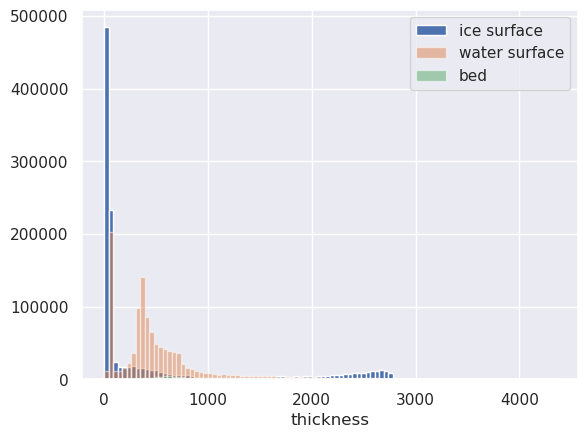

In [68]:
_ = ice_surface_prisms.thickness.plot.hist(bins=100, label="ice surface")
_ = water_surface_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="water surface")
_ = starting_bed_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="bed")


print(
    f"Number of ice surface prisms:",
    len(
        ice_surface_prisms.thickness.values[
            ~np.isnan(ice_surface_prisms.thickness.values)
        ]
    ),
)
print(
    f"Number of water surface prisms:",
    len(
        water_surface_prisms.thickness.values[
            ~np.isnan(water_surface_prisms.thickness.values)
        ]
    ),
)
print(
    f"Number of bed prisms:",
    len(
        starting_bed_prisms.thickness.values[
            ~np.isnan(starting_bed_prisms.thickness.values)
        ]
    ),
)

plt.legend()

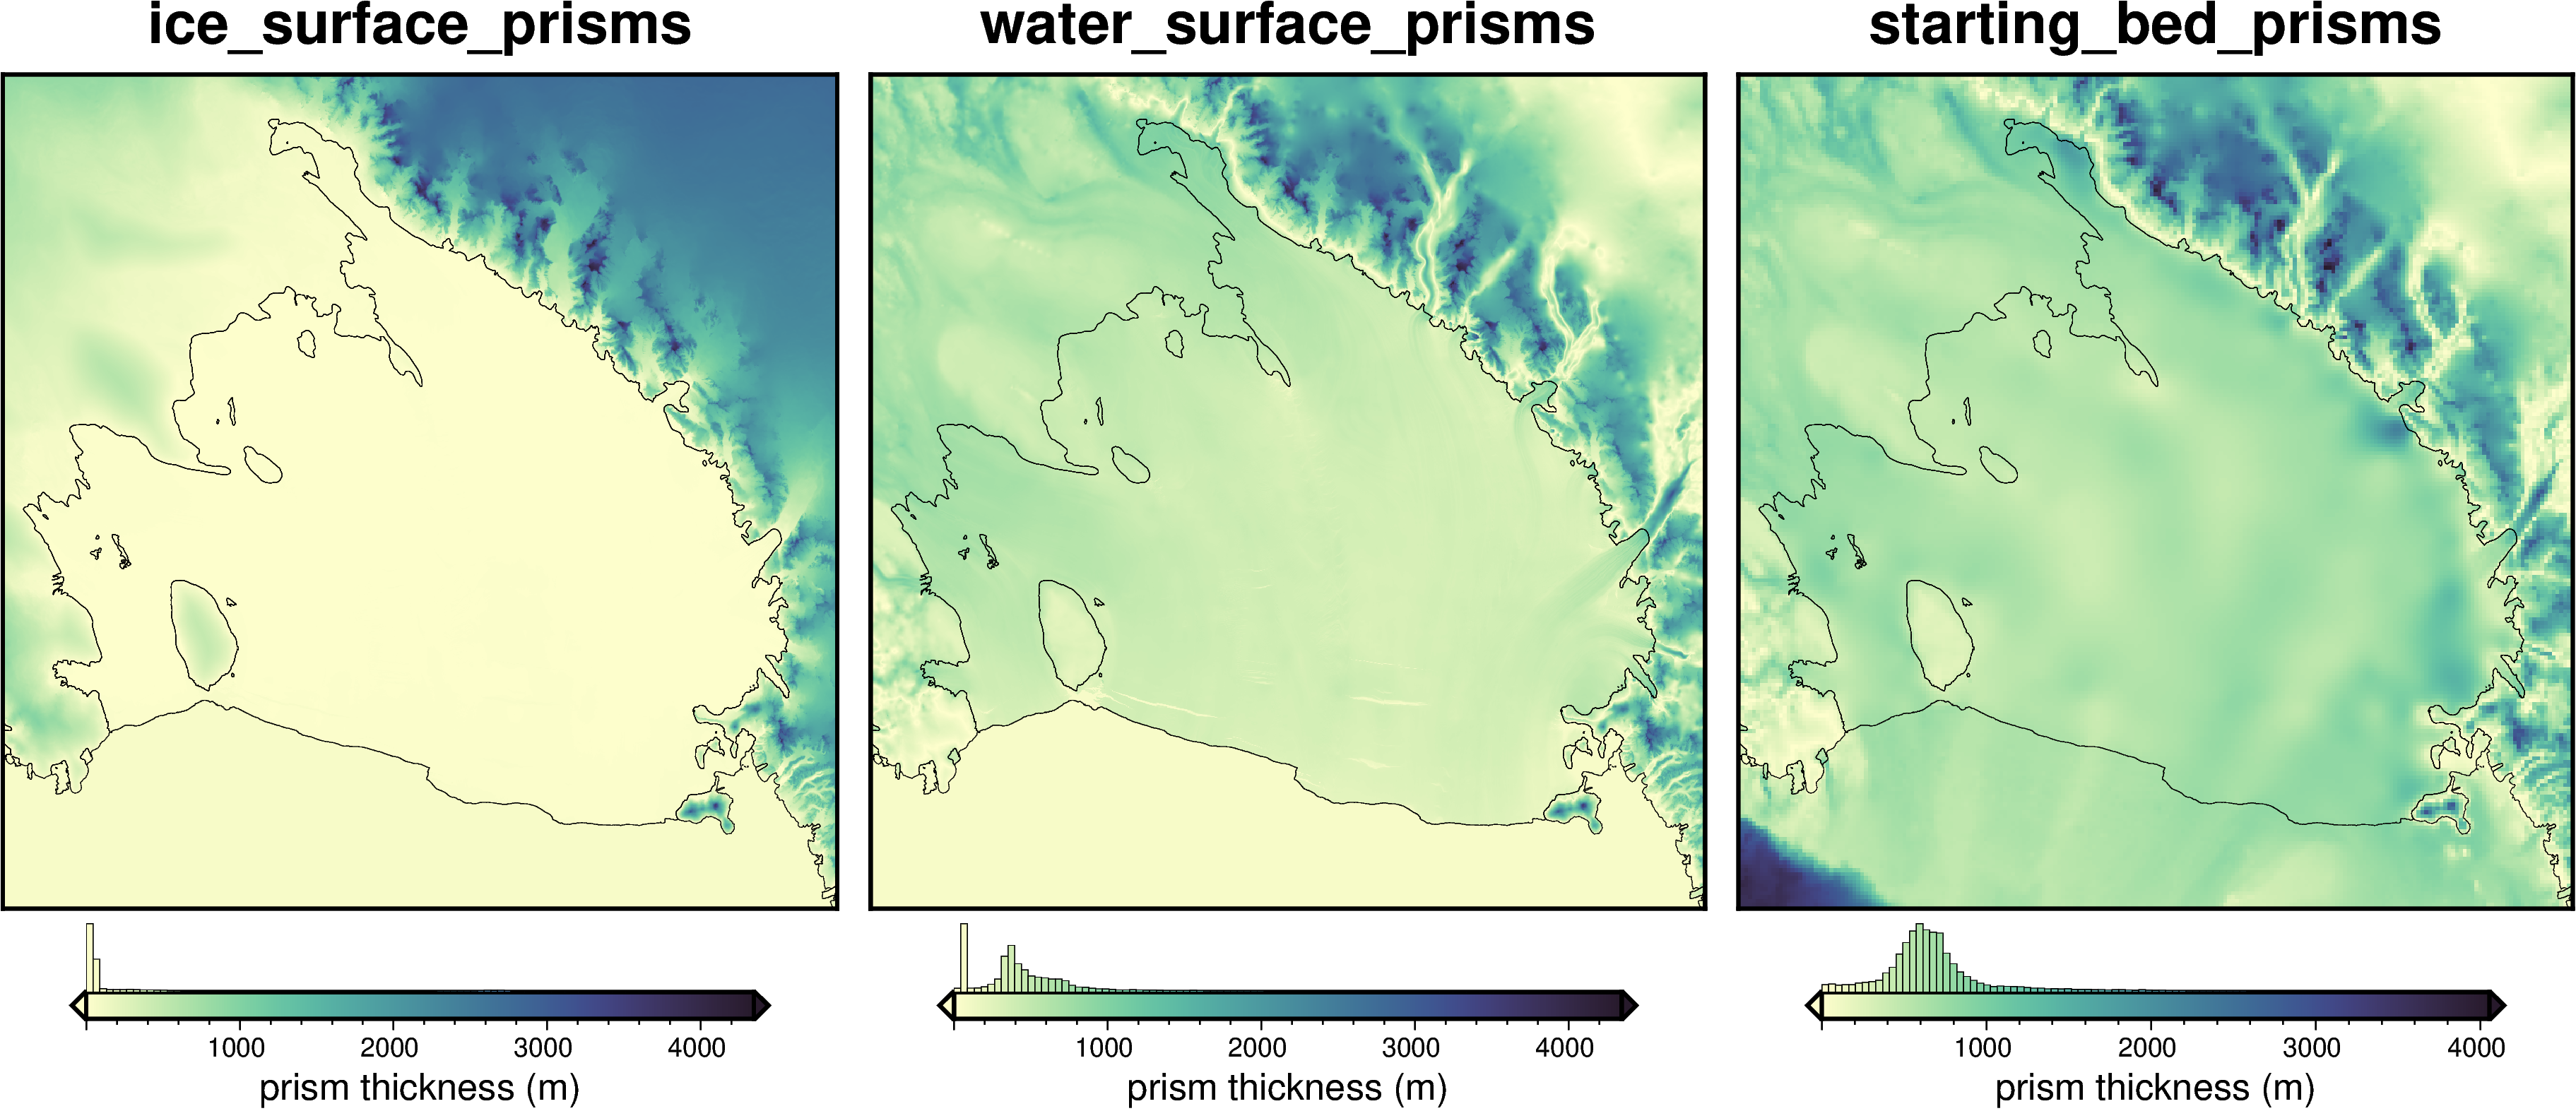

In [76]:
fig = maps.plot_grd(
    ice_surface_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="ice_surface_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
)

fig = maps.plot_grd(
    water_surface_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="water_surface_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig = maps.plot_grd(
    starting_bed_prisms.thickness,
    coast=True,
    coast_pen="0.2p,black",
    title="starting_bed_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

## Calculate gravity

In [78]:
# calculate gravity of prisms
forward_grid, forward_df = inv_utils.forward_grav_of_prismlayer(
    [
        ice_surface_prisms,
        water_surface_prisms,
        starting_bed_prisms,
    ],
    grav_df,
    names=[
        "ice_surface_prisms",
        "water_surface_prisms",
        "starting_bed_prisms",
    ],
    # thickness_threshold=1,
    progressbar=True,
    plot=False,
)

grav_df["ice_surface_grav"] = forward_df.ice_surface_prisms
grav_df["water_surface_grav"] = forward_df.water_surface_prisms
grav_df["starting_bed_grav"] = forward_df.starting_bed_prisms

grav_df.describe()

  0%|                                                 | 0/92518 [00:00<?, ?it/s]

  0%|                                                 | 0/92518 [00:00<?, ?it/s]

  0%|                                                 | 0/92518 [00:00<?, ?it/s]

northing        easting   upward          Gobs  surface_forward  \
count  9.251800e+04   92518.000000  92518.0  92518.000000     92518.000000   
mean  -9.774803e+05  -97107.022417   1000.0     -0.268222       -18.140200   
std    2.136572e+05  234474.012656      0.0     10.792959         3.061163   
min   -1.390000e+06 -580000.000000   1000.0    -35.006585       -34.994161   
25%   -1.147500e+06 -277500.000000   1000.0     -7.363493       -19.194658   
50%   -9.900000e+05 -102500.000000   1000.0     -0.175491       -18.927617   
75%   -8.225000e+05   90000.000000   1000.0      6.691260       -18.188273   
max   -4.375000e+05  395000.000000   1000.0     34.301253        17.511679   

       icebase_forward   bed_forward  terrain_effect     Gobs_corr  \
count     92518.000000  92518.000000    92518.000000  92518.000000   
mean         -1.507756    -19.165401      -35.355742     19.379734   
std           0.799791     10.529634       12.223534     10.834414   
min          -5.402379    -89.391614     -105.983143    -32.771128   
25%          -1.839410    -23.866783      -40.690775     12.670163   
50%          -1.409021    -18.690538      -35.586066     19.777290   
75%          -1.204281    -13.833556      -30.646711     26.362566   
max           4.451169     63.680871       88.721834     54.892395   

       Gobs_corr_shift  ...  ice_below_ell  air_below_ell  water_above_ell  \
count     92518.000000  ...   92518.000000   92518.000000     9.251800e+04   
mean        -15.035900  ...     -22.893736      -1.107934     5.378275e-05   
std          10.834414  ...      10.358692       1.355627     2.362955e-03   
min         -67.186761  ...     -73.707509      -5.455360     1.380005e-08   
25%         -21.745470  ...     -27.655000      -1.518268     5.205645e-08   
50%         -14.638343  ...     -21.522841      -0.865814     1.249550e-07   
75%          -8.053067  ...     -18.557194      -0.008238     4.370057e-07   
max          20.476762  ...      -0.080746      -0.000408     3.309254e-01   

       water_below_ell  bed_above_ell  Gobs_corr_proper  total_misfit  \
count     92518.000000   92518.000000      92518.000000  92518.000000   
mean        -12.462785       0.336884         35.087519     31.842519   
std          11.164184       3.579019         14.336378     16.361137   
min         -84.729025     -44.194939        -99.739513    -32.481493   
25%         -19.105518       0.003366         27.602919     20.587253   
50%         -10.356698       0.007179         35.175992     32.756874   
75%          -2.605718       0.025558         43.008178     42.727516   
max          -0.019392      90.132345         97.485176     96.343744   

       ice_surface_grav  water_surface_grav  starting_bed_grav  
count      92518.000000        92518.000000       92518.000000  
mean           0.464475           -1.807167         -34.006092  
std            3.058935            0.799767          10.527104  
min          -16.410854           -5.700550        -104.234950  
25%           -0.584815           -2.138881         -38.706004  
50%           -0.317118           -1.708553         -33.537469  
75%            0.418779           -1.503807         -28.680756  
max           36.119012            4.151706          48.836129  

[8 rows x 24 columns]

## Correct the observed gravity

In [102]:
grav_df["terrain_effect"] = (
    grav_df.ice_surface_grav + grav_df.water_surface_grav + grav_df.starting_bed_grav
)

grav_df["topo_corrected_disturbance"] = grav_df.Gobs - grav_df.terrain_effect

grav_df.describe()

northing        easting   upward          Gobs  surface_forward  \
count  9.251800e+04   92518.000000  92518.0  92518.000000     92518.000000   
mean  -9.774803e+05  -97107.022417   1000.0     -0.268222       -18.140200   
std    2.136572e+05  234474.012656      0.0     10.792959         3.061163   
min   -1.390000e+06 -580000.000000   1000.0    -35.006585       -34.994161   
25%   -1.147500e+06 -277500.000000   1000.0     -7.363493       -19.194658   
50%   -9.900000e+05 -102500.000000   1000.0     -0.175491       -18.927617   
75%   -8.225000e+05   90000.000000   1000.0      6.691260       -18.188273   
max   -4.375000e+05  395000.000000   1000.0     34.301253        17.511679   

       icebase_forward   bed_forward  ice_surface_grav  water_surface_grav  \
count     92518.000000  92518.000000      92518.000000        92518.000000   
mean         -1.507756    -19.165401          0.464475           -1.807167   
std           0.799791     10.529634          3.058935            0.799767   
min          -5.402379    -89.391614        -16.410854           -5.700550   
25%          -1.839410    -23.866783         -0.584815           -2.138881   
50%          -1.409021    -18.690538         -0.317118           -1.708553   
75%          -1.204281    -13.833556          0.418779           -1.503807   
max           4.451169     63.680871         36.119012            4.151706   

       starting_bed_grav  terrain_effect  topo_corrected_disturbance  
count       92518.000000    92518.000000                92518.000000  
mean          -34.006092      -35.348784                   35.080562  
std            10.527104       12.227188                   14.340738  
min          -104.234950     -105.989351                  -99.328513  
25%           -38.706004      -40.686693                   27.602789  
50%           -33.537469      -35.569102                   35.149320  
75%           -28.680756      -30.637046                   42.993349  
max            48.836129       88.310835                   97.307263

## Save and load results

In [103]:
grav_df.to_csv(
    "data/RIS_topo_corrections.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [104]:
grav_df = pd.read_csv(
    "data/RIS_topo_corrections.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

grav_df.describe()

northing        easting   upward          Gobs  surface_forward  \
count  9.251800e+04   92518.000000  92518.0  92518.000000     92518.000000   
mean  -9.774803e+05  -97107.022417   1000.0     -0.268222       -18.140200   
std    2.136572e+05  234474.012656      0.0     10.792959         3.061163   
min   -1.390000e+06 -580000.000000   1000.0    -35.006585       -34.994161   
25%   -1.147500e+06 -277500.000000   1000.0     -7.363493       -19.194658   
50%   -9.900000e+05 -102500.000000   1000.0     -0.175491       -18.927617   
75%   -8.225000e+05   90000.000000   1000.0      6.691260       -18.188273   
max   -4.375000e+05  395000.000000   1000.0     34.301253        17.511679   

       icebase_forward   bed_forward  ice_surface_grav  water_surface_grav  \
count     92518.000000  92518.000000      92518.000000        92518.000000   
mean         -1.507756    -19.165401          0.464475           -1.807167   
std           0.799791     10.529634          3.058935            0.799767   
min          -5.402379    -89.391614        -16.410854           -5.700550   
25%          -1.839410    -23.866783         -0.584815           -2.138881   
50%          -1.409021    -18.690538         -0.317118           -1.708553   
75%          -1.204281    -13.833556          0.418779           -1.503807   
max           4.451169     63.680871         36.119012            4.151706   

       starting_bed_grav  terrain_effect  topo_corrected_disturbance  
count       92518.000000    92518.000000                92518.000000  
mean          -34.006092      -35.348784                   35.080562  
std            10.527104       12.227188                   14.340738  
min          -104.234950     -105.989351                  -99.328513  
25%           -38.706004      -40.686693                   27.602789  
50%           -33.537469      -35.569102                   35.149320  
75%           -28.680756      -30.637046                   42.993349  
max            48.836129       88.310835                   97.307263

## Plot grids

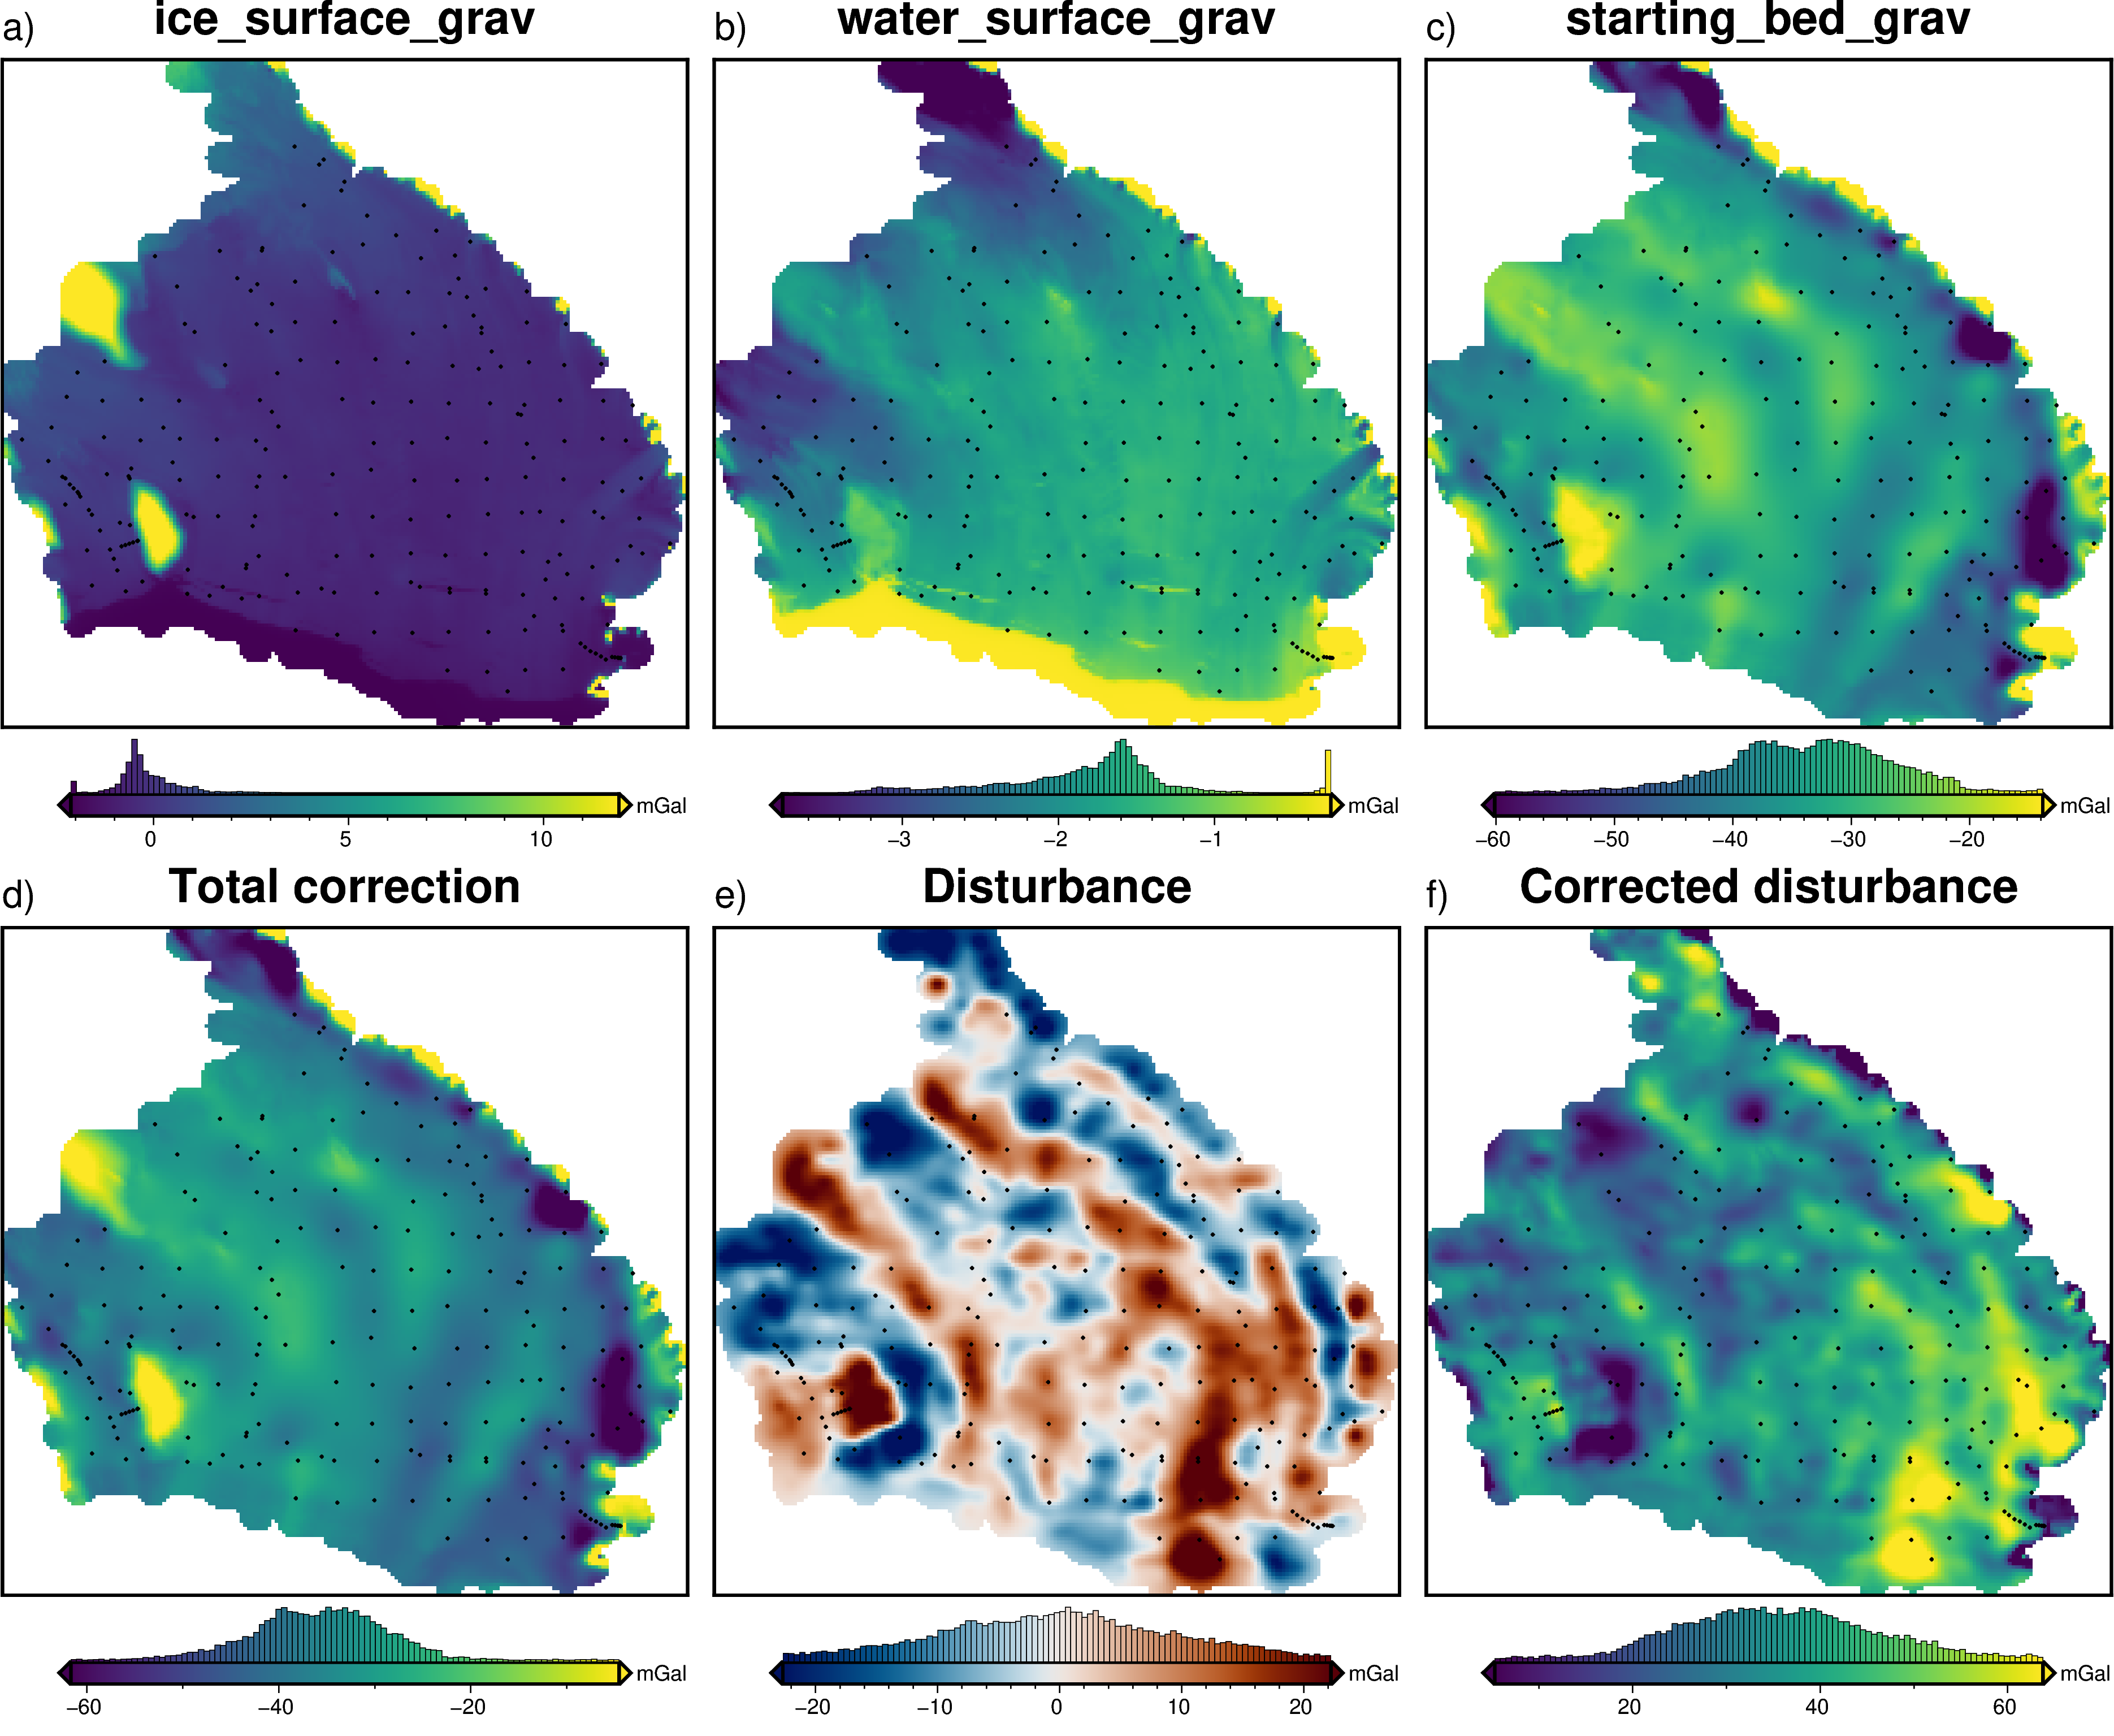

In [106]:
grav_grids = (
    grav_df[grav_df.test == False].set_index(["northing", "easting"]).to_xarray()
)

grids = [
    grav_grids.ice_surface_grav,
    grav_grids.water_surface_grav,
    grav_grids.starting_bed_grav,
    grav_grids.terrain_effect,
    grav_grids.Gobs,
    grav_grids.topo_corrected_disturbance,
]

titles = [
    "ice_surface_grav",
    "water_surface_grav",
    "starting_bed_grav",
    "Total correction",
    "Disturbance",
    "Corrected disturbance",
]

# lims = [utils.get_min_max(i, robust=True) for i in grids]
# lims = [min([i for i in lims[0]]), max([i for i in lims[1]])]
# lims = utils.get_min_max(grids[2])

for i, g in enumerate(grids):
    if i == 0:
        fig = None
        origin_shift = "initialize"
        xshift_amount = 1
        yshift_amount = 1
    elif i == 3:
        origin_shift = "both_shift"
        xshift_amount = -2
        yshift_amount = -1
    else:
        fig = fig
        origin_shift = "xshift"
        xshift_amount = 1
        yshift_amount = 1

    if i == 4:
        cmap = "vik+h0"
    else:
        cmap = "viridis"

    fig = maps.plot_grd(
        grid=g,
        fig_height=10,
        # cmap=f"vik+h{np.nanmedian(g)}",
        cmap=cmap,
        robust=True,
        # cpt_lims=lims,
        title=titles[i],
        cbar_unit="mGal",
        points=constraints[constraints.inside].rename(
            columns={"easting": "x", "northing": "y"}
        ),
        points_style="x0.05c",
        hist=True,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
    )
    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[i]})",
        font="16p,Helvetica,black",
        offset="j0/.3",
        no_clip=True,
    )

fig.show()

## Plot Terrain correction profiles

In [122]:
# lines = profile.draw_lines()

In [107]:
# # get clicked points
# df = utils.shapes_to_df(lines)
# # extract first and last
# a = (df.x.iloc[0], df.y.iloc[0])
# b = (df.x.iloc[-1], df.y.iloc[-1])

# siple coast profile
a = (-514139.22589550324, -886012.3396426054)
b = (-30871.591933855758, -595196.2984418197)

# ice front to CIR
a = (48403.646330947464, -1387918.0291082778)
b = (-221877.26567443524, -613795.4844574957)

In [110]:
grav_grids = grav_df.set_index(["northing", "easting"]).to_xarray()

# extract layers for profile plot
topo_grids = [
    surface,
    icebase,
    starting_bed,
]
topo_names = [
    "ice surface",
    "ice base",
    "bed",
]

data_grids = [
    grav_grids.ice_surface_grav,
    grav_grids.water_surface_grav,
    grav_grids.starting_bed_grav,
    grav_grids.terrain_effect,
    grav_grids.Gobs,
    grav_grids.topo_corrected_disturbance,
]

data_names = [
    "ice_surface_grav",
    "water_surface_grav",
    "starting_bed_grav",
    "Topographc mass correction",
    "Disturbance",
    "Topo-corrected disturbance",
]

layers_dict = profile.make_data_dict(
    names=topo_names,
    grids=topo_grids,
    colors=["lightskyblue", "darkblue", "lightbrown"],
)

data_dict = profile.make_data_dict(
    names=data_names,
    grids=data_grids,
    colors=[
        "gray",
        "blue",
        "darkorange",
        "red",
        "black",
        "purple",
    ],
    # axes = [0,0,0,0,0,0],
)

legend [WARNING]: File <stdin> is empty!
gmtset [WARNING]: Representation of font type not recognized. Using default.


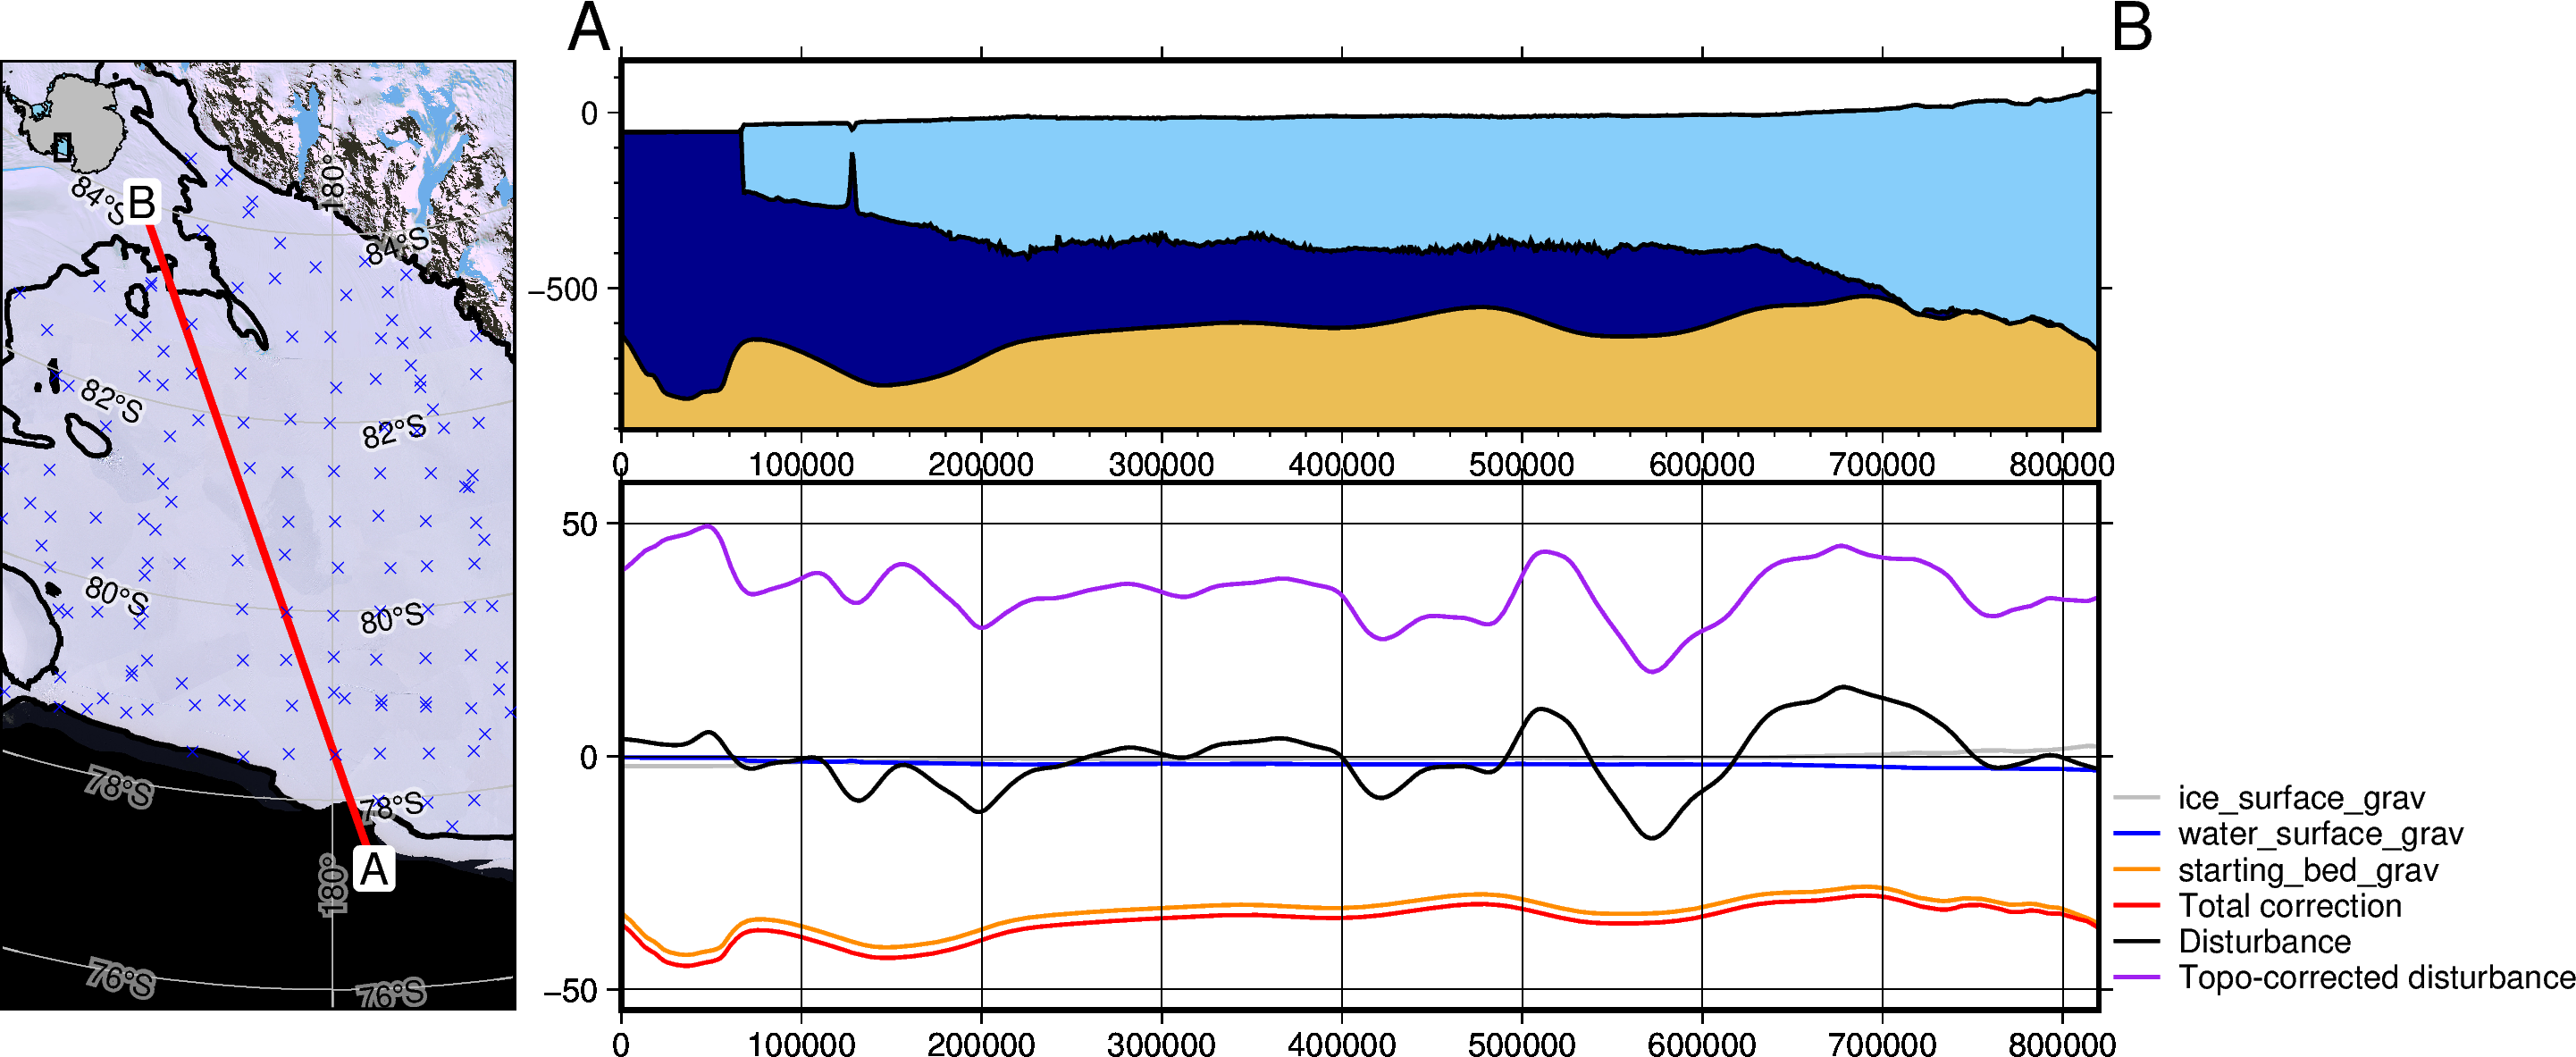

In [109]:
fig = profile.plot_profile(
    "points",
    start=a,
    stop=b,
    num=1000,
    add_map=True,
    map_buffer=0.2,
    subplot_orientation="horizontal",
    # subplot_orientation='vertical',
    data_dict=data_dict,
    layers_dict=layers_dict,
    share_yaxis=True,
    map_points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    data_height=5,
)
fig.show()

# Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `bathymetry` and `basement`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `bathymetry` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of the `bathymetry`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `bathymetry` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `bathymetry` and the low-resolution `bathymetry`. 

If we fail to accurately remove the `regional` signal, the resulting `bathymetry` after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field.  

In [111]:
constraints.describe()

northing        easting        upward       z_error  station_ID  \
count  2.140400e+04   21404.000000  21404.000000  21404.000000  223.000000   
mean  -8.617492e+05  -93839.803069     44.824669     10.244498   13.699552   
std    3.472164e+05  333326.483372   1008.627343      2.525460    8.608311   
min   -1.420000e+06 -580000.000000  -3581.791748     10.000000    1.000000   
25%   -1.260000e+06 -405000.000000   -638.929276     10.000000    1.000000   
50%   -7.300000e+05 -135000.000000   -460.563538     10.000000   19.000000   
75%   -5.600000e+05  245000.000000    627.659927     10.000000   19.000000   
max   -4.200000e+05  420000.000000   4053.667969     69.764264   25.000000   

            weights  
count  21404.000000  
mean       0.009907  
std        0.000909  
min        0.000205  
25%        0.010000  
50%        0.010000  
75%        0.010000  
max        0.010000

DC shifted observed gravity by 62.87mGal to match forward gravity.
Highest score: 0.9422696154387156
Best damping: 4.6415888336127916e-24


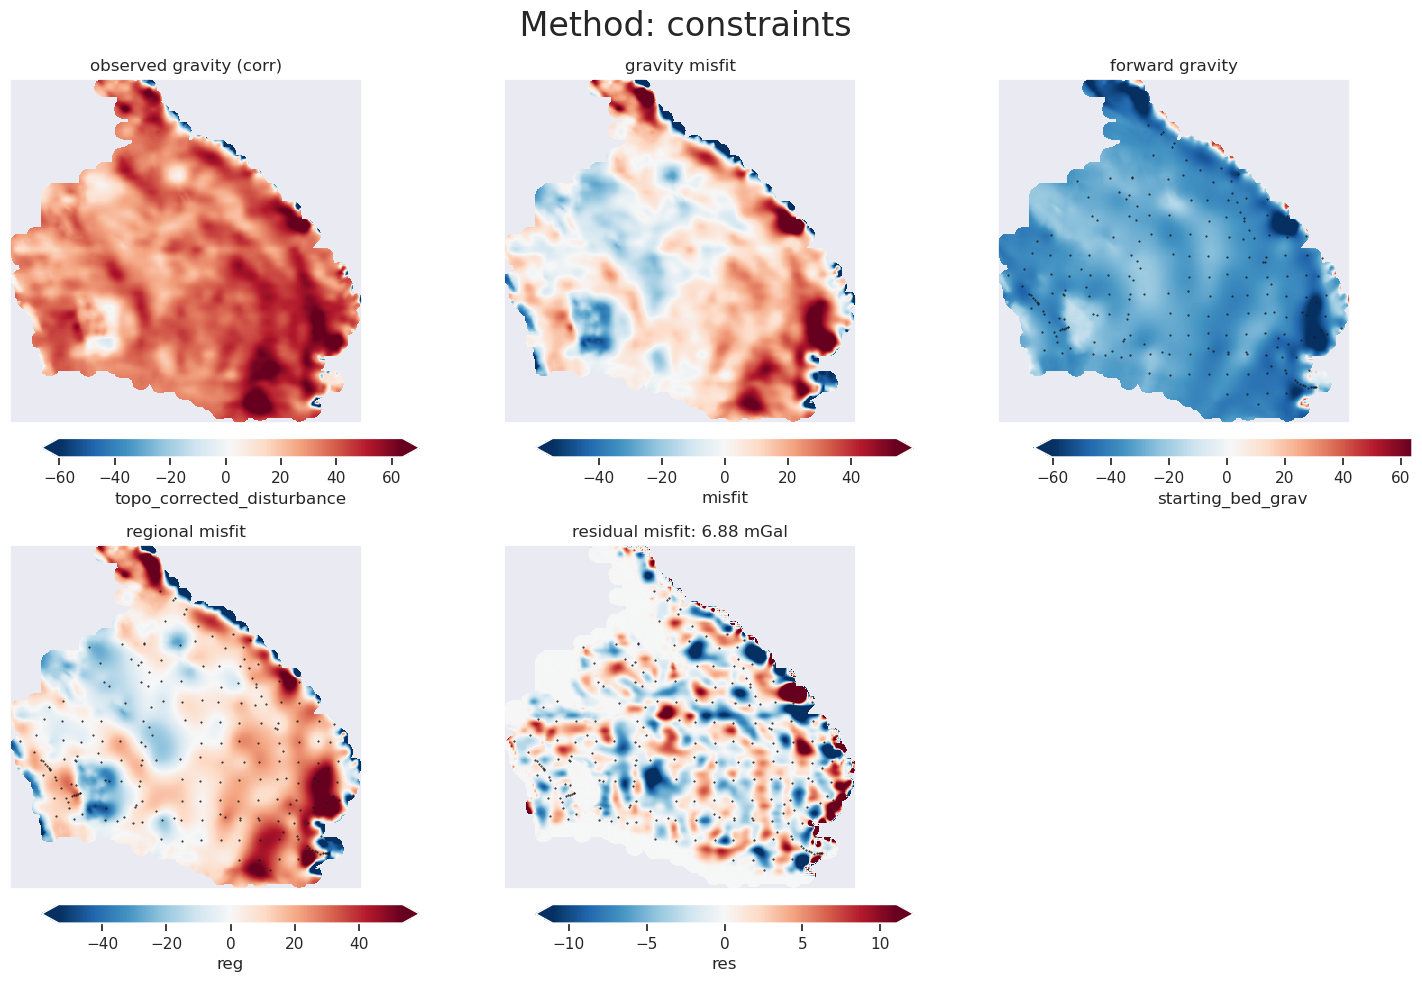

In [113]:
regional_kwargs = dict(
    input_grav=grav_df,
    input_forward_column="starting_bed_grav",
    input_grav_column="topo_corrected_disturbance",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    constraints=constraints,
    grid_method="verde",
    dampings=np.logspace(-50, -10, num=4),
    # grid_method="pygmt",
    # tension_factor = 0,
    # constraint_block_size=grav_spacing,
    # block_size= grav_spacing,
    regional_method="constraints",
    # regional_method = "trend",
    # trend=10,
    # regional_method = "eq_sources",
    # eq_sources = 500e3,
    constraint_weights_col="weights",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", sp.linalg.LinAlgWarning)
    df_anomalies = regional.regional_seperation(
        **regional_kwargs,
    )

anom_grids = plotting.anomalies_plotting(
    df_anomalies,
    title=f" Method: {regional_kwargs.get('regional_method')}",
    constraints=constraints[
        constraints.inside
    ],  # .rename(columns={"easting":"x","northing":"y"}),
    input_forward_column="starting_bed_grav",
    input_grav_column="topo_corrected_disturbance",
    # plot_type="pygmt",
    plot_type="xarray",
    robust=True,
)

### Save and load results

In [49]:
df_anomalies.to_csv(
    "data/RIS_topo_corrections.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [15]:
df_anomalies = pd.read_csv(
    "data/RIS_topo_corrections.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

df_anomalies

northing   easting   test  upward       Gobs  surface_forward  \
0     -1390000.0   47500.0   True  1000.0   2.368602       -20.694977   
1     -1390000.0   50000.0  False  1000.0   2.642928       -20.694484   
2     -1390000.0   52500.0   True  1000.0   2.925000       -20.693793   
3     -1390000.0   55000.0  False  1000.0   3.213357       -20.692648   
4     -1390000.0   57500.0   True  1000.0   3.506204       -20.690074   
...          ...       ...    ...     ...        ...              ...   
91765  -437500.0 -200000.0   True  1000.0 -11.748526        -4.080706   
91766  -437500.0 -197500.0   True  1000.0 -11.729424        12.997936   
91767  -437500.0 -195000.0   True  1000.0 -11.644636         4.152685   
91768  -437500.0 -192500.0   True  1000.0 -11.501089         2.455978   
91769  -437500.0 -190000.0   True  1000.0 -11.309474         3.682493   

       icebase_forward  Gobs_corr  bed_forward  Gobs_corr_shift      misfit  \
0             0.043359  23.020219   -18.111170       -11.647777    6.463393   
1             0.043358  23.294053   -18.151591       -11.373943    6.777648   
2             0.043378  23.575415   -18.020505       -11.092582    6.927923   
3             0.043449  23.862556   -17.858614       -10.805441    7.053173   
4             0.043684  24.152594   -17.702407       -10.515403    7.187004   
...                ...        ...          ...              ...         ...   
91765         1.830722  -9.498542    32.246321       -44.166539  -76.412859   
91766         3.840271 -28.567631    40.293215       -63.235628 -103.528843   
91767         2.803150 -18.600471    48.163267       -53.268468 -101.431736   
91768         2.613939 -16.571005    46.867578       -51.239002  -98.106581   
91769         2.777667 -17.769634    45.332128       -52.437631  -97.769759   

              reg           res  
0        6.462314  1.079061e-03  
1        6.777648 -2.308105e-07  
2        6.939568 -1.164526e-02  
3        7.053173  4.361400e-07  
4        7.187837 -8.322639e-04  
...           ...           ...  
91765  -73.210279 -3.202580e+00  
91766  -83.366726 -2.016212e+01  
91767  -93.954183 -7.477553e+00  
91768  -99.795217  1.688636e+00  
91769 -104.708359  6.938600e+00  

[91770 rows x 13 columns]

In [51]:
df_anomalies.describe()

northing        easting   upward          Gobs  surface_forward  \
count  9.177000e+04   91770.000000  91770.0  91770.000000     91770.000000   
mean  -9.797926e+05  -96935.055029   1000.0     -0.239521       -18.191799   
std    2.110968e+05  234306.952782      0.0     10.370910         2.966927   
min   -1.390000e+06 -580000.000000   1000.0    -26.611350       -34.994161   
25%   -1.147500e+06 -277500.000000   1000.0     -7.478945       -19.196449   
50%   -9.925000e+05 -100000.000000   1000.0     -0.262338       -18.932637   
75%   -8.250000e+05   90000.000000   1000.0      6.742612       -18.213737   
max   -4.375000e+05  395000.000000   1000.0     26.245940        17.511679   

       icebase_forward     Gobs_corr   bed_forward  Gobs_corr_shift  \
count     91770.000000  91770.000000  91770.000000     91770.000000   
mean         -1.502659     19.454937    -19.175190       -15.213060   
std           0.778539     10.420340     10.347281        10.420340   
min          -5.234137    -33.489906    -89.391614       -68.157903   
25%          -1.831164     12.584688    -23.824452       -22.083309   
50%          -1.407794     19.652328    -18.673822       -15.015669   
75%          -1.205082     26.280980    -13.846715        -8.387016   
max           4.451169     46.314753     63.680871        11.646757   

             misfit           reg           res  
count  91770.000000  91770.000000  9.177000e+04  
mean       3.962130      4.147877 -1.857466e-01  
std       14.038891     14.032827  5.321883e+00  
min     -131.682151   -140.885435 -4.095437e+01  
25%       -3.780331     -3.410607 -2.029040e+00  
50%        4.053673      4.219120 -1.342337e-07  
75%       11.913257     12.851556  1.582735e+00  
max       68.259916     50.219247  7.005928e+01

# Plot Inputs

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


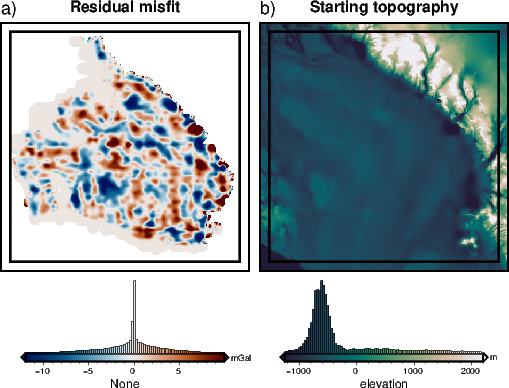

In [52]:
plotting.inputs_plotting(
    df_anomalies,
    starting_bed,
    buffer_region=buffer_region,
    inversion_region=inversion_region,
    robust=True,
    # points = constraints,
    # points_style = "c0.05c",
    hist=True,
    cbar_yoffset=1.5,
)